In [1]:
data = 'https://raw.githubusercontent.com/gastonstat/CreditScoring/refs/heads/master/CreditScoring.csv'

In [2]:
!wget $data

--2024-10-28 11:39:31--  https://raw.githubusercontent.com/gastonstat/CreditScoring/refs/heads/master/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.004s  

2024-10-28 11:39:32 (40.8 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as pyplot
%matplotlib inline

### 6.2 Data cleaning and preparation

In [2]:
df = pd.read_csv('CreditScoring.csv')

In [3]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
df.columns = df.columns.str.lower()

In [5]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [6]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)


In [7]:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

In [8]:
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)


In [9]:
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [12]:
df.describe().max()

seniority      4455.0
time           4455.0
age            4455.0
expenses       4455.0
income         4421.0
assets       300000.0
debt          30000.0
amount         5000.0
price         11140.0
dtype: float64

In [13]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [14]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [17]:
del df_train['status']
del df_val['status']
del df_test['status']

### 6.3 Decision trees

In [18]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [19]:
xi = df_train.iloc[0].to_dict()

In [20]:
assess_risk(xi)

'ok'

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

In [22]:
train_dicts = df_train.to_dict(orient='records')

In [23]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [24]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [25]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [26]:
y_pred = dt.predict_proba(X_val)[:,1]

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
roc_auc_score(y_val, y_pred)

np.float64(0.6564323944685282)

In [29]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

np.float64(0.9990592079319476)

In [30]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [31]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [32]:
from sklearn.tree import export_text

In [33]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



### 6.4 Decision Tree Learning Algorithm

In [43]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [35]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


In [36]:
from IPython.display import display

In [37]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [38]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    display(df_right)

    print()

0


,assets,status
2,0,default


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



2000


,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



3000


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok



4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok



5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok



8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


In [40]:
T = 4000

print(T)
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_right.status.value_counts(normalize=True))

print()

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64



In [41]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [44]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [45]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [46]:
Ts = [500, 1000, 2000]

In [47]:
thresholds = {
    'assets' : [0, 2000, 3000, 4000, 5000, 8000],
    'debt' : [500, 1000, 2000]
}

for feature, Ts in thresholds.items():
    print('###############')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
        
    print('###############')

###############
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

###############
###############
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64

###############


### 6.5 Decision Trees Parameter Tuning

In [48]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.755
  10 -> 0.682
  15 -> 0.664
  20 -> 0.662
None -> 0.658


In [50]:
scores = []

for d in [4, 5, 6]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [54]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4,1,0.761283
1,4,2,0.761283
2,4,5,0.761283
3,4,10,0.761283
4,4,15,0.763726


In [58]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
22,6,15,0.785486
21,6,10,0.777122
24,6,100,0.776077
23,6,20,0.772983
14,5,20,0.772868
13,5,15,0.772369
25,6,200,0.768267
11,5,5,0.767555
9,5,1,0.766320
10,5,2,0.766320


In [59]:
df_scores_pivot = df_scores.pivot_table(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.757
2                 0.761  0.766  0.752
5                 0.761  0.768  0.759
10                0.761  0.765  0.777
15                0.764  0.772  0.785
20                0.761  0.773  0.773
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

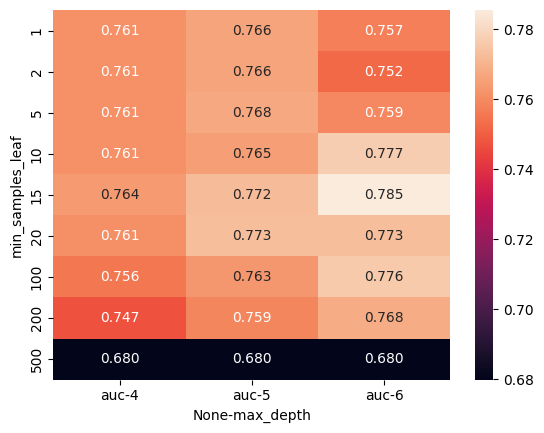

In [60]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [62]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

### 6.6 Ensembles and Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [71]:
y_pred = rf.predict_proba(X_val)[:,1]

In [72]:
roc_auc_score(y_val, y_pred)

np.float64(0.78614589135647)

In [80]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

In [81]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

In [82]:
df_scores

,n_estimators,auc
0,10,0.786146
1,20,0.796324
2,30,0.810134
3,40,0.811079
4,50,0.813261
5,60,0.814836
6,70,0.816168
7,80,0.817742
8,90,0.817260
9,100,0.817200


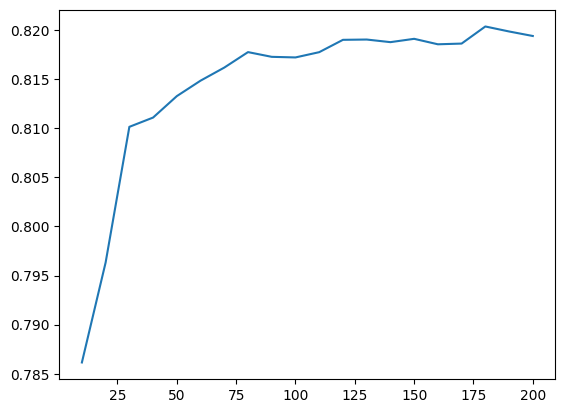

In [83]:
pyplot.plot(df_scores.n_estimators, df_scores.auc)

In [84]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [85]:
columns = ['max_depth', 'n_estimators', 'auc']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.798355
1,5,20,0.802851
2,5,30,0.802339
3,5,40,0.801476
4,5,50,0.801240


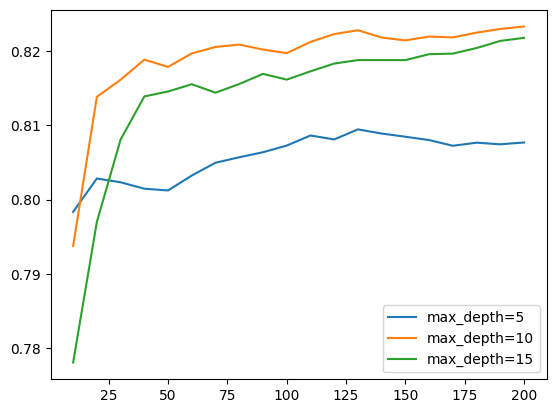

In [86]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    pyplot.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

pyplot.legend()

In [88]:
max_depth = 10

In [89]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [93]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']

df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.793760
1,1,20,0.813849
2,1,30,0.816149
3,1,40,0.818856
4,1,50,0.817875


In [96]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

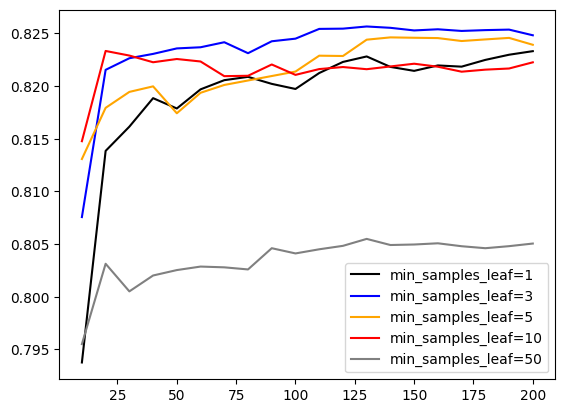

In [97]:
for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    pyplot.plot(df_subset.n_estimators, df_subset.auc, color=col, label='min_samples_leaf=%d' % s)

pyplot.legend()

In [98]:
min_samples_leaf = 3

In [99]:
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)